In [8]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import argparse
import yaml
import datetime
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from utils.preprocessing import prepare_dataset
from utils import models_new
from utils import callbacks
from utils import losses

import Levenshtein as lev

In [9]:
def load_data(config):
    """ Function to load all the data """
    # Parameters
    file_thermo = config['file_thermo']
    file_meso   = config['file_meso']
    seq_length  = config['seq_length']
    max_samples = config['max_samples']
    
    thermo_train, thermo_val, n_thermo_train, n_thermo_val = prepare_dataset(file_thermo, 
                                                                             seq_length = seq_length,
                                                                             max_samples = max_samples)
    
    meso_train, meso_val, n_meso_train, n_meso_val = prepare_dataset(file_meso,
                                                                     seq_length = seq_length,
                                                                     max_samples = max_samples)

    data = {'thermo_train': thermo_train,
            'meso_train': meso_train,
            'thermo_val': thermo_val,
            'meso_val': meso_val,
            'n_thermo_train': n_thermo_train,
            'n_meso_train': n_meso_train,
            'n_thermo_val': n_thermo_val,
            'n_meso_val': n_meso_val}
    
    return data

def load_models(config):
    """Create all models that is used in cycle gan""" 
    
    model_type = config["Generator"]["type"]
    G_filters = config["Generator"]["filters"]
    G_sizes   = config["Generator"]["kernels"]
    G_dilation= config["Generator"]["dilations"]
    G_gumbel = config["Generator"]["use_gumbel"]
    G_temperature = config["Generator"]["temperature"]


    D_filters = config["Discriminator"]["filters"]
    D_sizes   = config["Discriminator"]["kernels"]
    D_dilation= config["Discriminator"]["dilations"]
    D_strides = config["Discriminator"]["strides"]
    
    if config["Losses"]["loss"] == 'Non-Reducing':
        D_activation = 'sigmoid'
    else:
        D_activation = 'linear'
    
    vocab = config["Vocab_size"] 

    G    = models_new.Generator_res(G_filters, G_sizes, G_dilation, vocab, use_gumbel = G_gumbel, temperature = G_temperature)
    F    = models_new.Generator_res(G_filters, G_sizes, G_dilation, vocab, use_gumbel = G_gumbel, temperature = G_temperature) 
    D_x  = models_new.Discriminator(D_filters, D_sizes, D_strides, D_dilation, vocab, activation = D_activation)
    D_y  = models_new.Discriminator(D_filters, D_sizes, D_strides, D_dilation, vocab, activation = D_activation)
    
    return G, F, D_x, D_y

def load_classifier(config):
    vocab         = config['Vocab_size']
    filters       = config['filters']
    kernels       = config['kernels']
    dilations     = config['dilations']
    strides       = config['strides']
    use_attention = config['use_attention']
    file          = config['file']
    
    reg_model = models_new.Classifier(filters, kernels, strides, dilations, vocab)
    reg_model.load_weights(file)
    return reg_model

def load_losses(config):
    if config['loss'] == 'Non-Reduceing':
        loss_obj = losses.NonReduceingLoss()
    elif config['loss'] == 'Wasserstein':
        loss_obj = losses.WassersteinLoss()
    elif config['loss'] == 'Hinge':
        loss_obj = losses.HingeLoss()
    else:
        loss_obj = losses.NonReduceingLoss()
    return loss_obj

def load_optimizers(config):
    lr_D   = config['learning_rate_discriminator']
    lr_G   = config['learning_rate_generator']
    beta_D = config['beta_1_discriminator']
    beta_G = config['beta_1_generator']
    optimizers = {}
    if config['optimizer_discriminator'] == 'Adam':
        optimizers['opt_D_x'] = keras.optimizers.Adam(learning_rate = lr_D, beta_1 = beta_D) 
        optimizers['opt_D_y'] = keras.optimizers.Adam(learning_rate = lr_D, beta_1 = beta_D)
    else:
        optimizers['opt_D_x'] = keras.optimizers.SGD(learning_rate = lr_D, momentum = beta_D) 
        optimizers['opt_D_y'] = keras.optimizers.SGD(learning_rate = lr_D, momentum = beta_D)
        
    if config['optimizer_generator'] == 'Adam':
        optimizers['opt_G'] = keras.optimizers.Adam(learning_rate = lr_G, beta_1 = beta_G) 
        optimizers['opt_F'] = keras.optimizers.Adam(learning_rate = lr_G, beta_1 = beta_G)
    else: 
        optimizers['opt_G'] = keras.optimizers.SGD(learning_rate = lr_G, momentum = beta_G) 
        optimizers['opt_F'] = keras.optimizers.SGD(learning_rate = lr_G, momentum = beta_G)
        
    return optimizers

def load_metrics(config):
    metrics = {}
    metrics['loss_G']       = tf.keras.metrics.Mean('loss_G', dtype=tf.float32)
    metrics['loss_cycle_x'] = tf.keras.metrics.Mean('loss_cycle_x', dtype=tf.float32)
    metrics['loss_disc_y']  = tf.keras.metrics.Mean('loss_disc_y', dtype=tf.float32)
    metrics['loss_F']       = tf.keras.metrics.Mean('loss_F', dtype=tf.float32)
    metrics['loss_cycle_y'] = tf.keras.metrics.Mean('loss_cycle_y', dtype=tf.float32)
    metrics['loss_disc_x']  = tf.keras.metrics.Mean('loss_disc_x', dtype=tf.float32)

    metrics['temp_diff_x']  = tf.keras.metrics.Mean('temp_diff_x', dtype=tf.float32)
    metrics['temp_diff_y']  = tf.keras.metrics.Mean('temp_diff_y', dtype=tf.float32)

    metrics['acc_x']        = tf.keras.metrics.CategoricalAccuracy()
    metrics['cycled_acc_x'] = tf.keras.metrics.CategoricalAccuracy()
    metrics['acc_y']        = tf.keras.metrics.CategoricalAccuracy()
    metrics['cycled_acc_y'] = tf.keras.metrics.CategoricalAccuracy()
    
    return metrics

class CycleGan(tf.keras.Model):

    def __init__(self, config, callbacks=None):
        super(CycleGan, self).__init__()
        self.G, self.F, self.D_x, self.D_y = load_models(config['CycleGan'])
        self.classifier = load_classifier(config['Classifier'])
        self.lambda_cycle = config['CycleGan']['lambda_cycle']
        self.lambda_id    = config['CycleGan']['lambda_id'] 
        self.add  = tf.keras.layers.Add()
        self.pcaobj = callbacks
    def compile( self, loss_obj, optimizers):
        
        super(CycleGan, self).compile()
        
        self.gen_G_optimizer = optimizers['opt_G']
        self.gen_F_optimizer = optimizers['opt_F']
        self.disc_X_optimizer = optimizers['opt_D_x']
        self.disc_Y_optimizer = optimizers['opt_D_y']
        
        self.generator_loss_fn = loss_obj.generator_loss_fn
        self.discriminator_loss_fn = loss_obj.discriminator_loss_fn
        self.cycle_loss_fn = loss_obj.cycle_loss_fn
        self.identity_loss_fn = loss_obj.cycle_loss_fn
    
    @tf.function
    def train_step(self, batch_data):

        _, X_bin, W_x= batch_data[0]
        _, Y_bin, W_y= batch_data[1]


        with tf.GradientTape(persistent=True) as tape:
            _, X_bin, W_x = batch_data[0]
            _, Y_bin, W_y= batch_data[1]

            fake_y, _ = self.G(X_bin, training=True)
            #print(fake_y.numpy()[0,:20,:])
            fake_x, _ = self.F(Y_bin, training=True)
            #print('fake_y', fake_y.numpy()[0,:20,:])
            # Identity mapping
            same_x, _ = self.F(X_bin, training=True)
            same_y, _ = self.G(Y_bin, training=True)

            # Cycle: x -> y -> x
            cycled_x, _ = self.F(fake_y, training=True)
            cycled_y, _ = self.G(fake_x, training=True)

            # Discriminator output
            disc_real_y, _ = self.D_y(Y_bin, training=True)
            disc_fake_y, _ = self.D_y(fake_y, training=True)
            disc_real_x, _ = self.D_x(X_bin, training=True)
            disc_fake_x, _ = self.D_x(fake_x, training=True)


            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)
            #print('Loss G:', gen_G_loss)

            id_G_loss = self.cycle_loss_fn(Y_bin, same_y, W_y) 
            id_F_loss = self.cycle_loss_fn(X_bin, same_x, W_x) 
            #print('Id loss G:', id_G_loss)
            
            gen_cycle_x_loss = self.cycle_loss_fn(X_bin, cycled_x, W_x) 
            gen_cycle_y_loss = self.cycle_loss_fn(Y_bin, cycled_y, W_y)
            #print('C loss G', gen_cycle_x_loss)


            # Discriminator loss
            tot_loss_G = gen_G_loss + gen_cycle_x_loss * self.lambda_cycle + id_G_loss * self.lambda_cycle * self.lambda_id
            tot_loss_F = gen_F_loss + gen_cycle_y_loss * self.lambda_cycle + id_F_loss * self.lambda_cycle * self.lambda_id
            #print('total loss G', tot_loss_G)
            loss_D_y = self.discriminator_loss_fn(disc_real_y, disc_fake_y)
            loss_D_x = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
        
        grads_G = tape.gradient(tot_loss_G, self.G.trainable_variables)
        
        grads_F = tape.gradient(tot_loss_F, self.F.trainable_variables)

        # Get the gradients for the discriminators
        grads_disc_y = tape.gradient(loss_D_y, self.D_y.trainable_variables)
        grads_disc_x = tape.gradient(loss_D_x, self.D_x.trainable_variables)

        # Update the weights of the generators 
        self.gen_G_optimizer.apply_gradients(zip(grads_G, self.G.trainable_variables))  
        self.gen_F_optimizer.apply_gradients(zip(grads_F, self.F.trainable_variables))

        # Update the weights of the discriminators
        self.disc_Y_optimizer.apply_gradients(zip(grads_disc_y, self.D_y.trainable_variables))
        self.disc_X_optimizer.apply_gradients(zip(grads_disc_x, self.D_x.trainable_variables))

        return {
            "Gen_G_loss": gen_G_loss,
            "Cycle_X_loss": gen_cycle_x_loss,
            "Disc_X_loss": loss_D_x,
            "Gen_F_loss": gen_F_loss,
            "Cycle_Y_loss": gen_cycle_y_loss,
            "Disc_Y_loss": loss_D_y
        }, ((fake_y, fake_x),(cycled_x, cycled_y))
    
    #@tf.function
    def validate_step(self, val_x, val_y,data, step):
        # PCA clustering to measure diversity
        W_x = np.zeros((data['n_meso_val'],512)) #TODO
        W_y = np.zeros((data['n_thermo_val'],512)) #TODO
        gen_x = np.zeros((data['n_thermo_val'],512,21))
        gen_y = np.zeros((data['n_meso_val'],512,21))

        
        for k, item in enumerate(val_x):
            _, X_bin, w_x = item    
            logits, _ = self.G(X_bin)
            #tmp = tf.math.argmax(logits, axis = -1).numpy()
            gen_y[k,:, :] = logits #tmp    
            W_x[k,:] = w_x.numpy()

        #print(data['n_meso_val'])
        for k, item in enumerate(val_y):
            _, Y_bin, w_y = item    
            logits, _ = self.F(Y_bin)
            #tmp = tf.math.argmax(logits, axis = -1).numpy()
            gen_x[k,:, :] = logits #tmp
            W_y[k,:] = w_y.numpy()


        df_gen_y = zip(list(gen_y), list(gen_y), list(W_x))
        df_gen_x = zip(list(gen_x), list(gen_x), list(W_y)) 

        self.pcaobj(df_gen_y, df_gen_x, data['n_thermo_val'], data['n_meso_val'], step=step)

        # Get temp dif
        diff=0
        for k, item in enumerate(val_x):
            _, X_bin, W_x = item 
            logit, _ = self.G(X_bin)
            W_x = tf.reshape(W_x, shape=(1,512,1))
            W_x = tf.repeat(W_x, repeats=21, axis=2)
            trans_x = tf.math.multiply(W_x, logit)
            logits_real  = self.classifier(X_bin)
            logits_trans = self.classifier(trans_x)
            diff += tf.math.reduce_mean(tf.math.subtract(logits_trans,logits_real))
            diff_x = diff/k
        diff=0
        for k, item in enumerate(val_y):
            _, Y_bin, W_y = item 
            logit, _ = self.F(Y_bin)
            W_y = tf.reshape(W_y, shape=(1,512,1))
            W_y = tf.repeat(W_y, repeats=21, axis=2)
            trans_y = tf.math.multiply(W_y, logit)
            logits_real  = self.classifier(Y_bin)
            logits_trans = self.classifier(trans_y)
            diff += tf.math.reduce_mean(tf.math.subtract(logits_trans,logits_real))
            diff_y = diff/k

        return diff_x, diff_y
    
def convert_table(seq, w):    
    aas = 'ACDEFGHIKLMNPQRSTVWYX'
    dict_ = {i:aa for i, aa in enumerate(aas)}
    seq_str = "".join([dict_[res] for res in seq[w==1]])
    return seq_str 

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"]= "1"
config = "config.yaml"
# Get time
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Load configuration file
with open(config, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)



# Load training data
data = load_data(config['Data'])

# Callbacks
cb = callbacks.PCAPlot(data['thermo_train'].as_numpy_iterator(), data['meso_train'].as_numpy_iterator(), data['n_thermo_train'], data['n_meso_train'], logdir=os.path.join(config['Log']['base_dir'],time,'img')) 

# Initiate model
model = CycleGan(config, callbacks = cb)

loss_obj  = load_losses(config['CycleGan']['Losses'])
optimizers = load_optimizers(config['CycleGan']['Optimizers'])
model.compile(loss_obj, optimizers)
#weights = "../results/20210519-213219/weights/cycle_gan_model"
#weights = "../results/20210519-213240/weights/cycle_gan_model"
weights = "../results/20210519-113509/weights/cycle_gan_model"
model.load_weights(weights)
# Initiate Training

#history = train(config, model, data, time)

#writing results


# Save model


In [11]:
data = load_data(config['Data'])

In [53]:
dir_results = os.path.dirname(os.path.dirname(weights))  #"../results/20210519-213240/"

FASTA_STRING = ">{} {} {}\n{}\n"

batches_x = data['meso_val'].batch(32, drop_remainder=True) 
batches_y = data['thermo_val'].batch(32, drop_remainder=True)

mutation_prob_matrix = np.zeros([21,21])
concerved_prob_matrix = np.zeros([21,21])

conc_seq_query = tf.zeros([1,512], dtype = tf.int64)
conc_seq_style = tf.zeros([1,512], dtype = tf.int64)
conc_id        = tf.constant("start", dtype=tf.string, shape=[1], name='Const')
conc_w         = tf.zeros([1,512], dtype = tf.int64)
conc_temp      = tf.zeros([32,1], dtype=tf.float32)

for step, batch_data in enumerate(zip(batches_x,batches_y)):
    id_, X_bin, W_x = batch_data[0]
    _, Y_bin, W_y= batch_data[1]
    

    # Fake data
    X_int = tf.math.argmax(X_bin, axis=-1)
    fake_y, _ = model.G(X_bin, training=True)
    fake_y_int = tf.math.argmax(fake_y, axis= -1) 
    fake_y_onehot = tf.one_hot(fake_y_int, 21)
    
    W_x_tmp = tf.repeat(tf.reshape(W_x, shape=(32,512,1)), 21, axis = -1)
    
    fake_y_onehot = tf.math.multiply(fake_y_onehot, W_x_tmp)
    temp_fake_y = model.classifier(fake_y_onehot)
    temp_X = model.classifier(X_bin)

    temp_diff = temp_fake_y - temp_X
    conc_seq_style = tf.concat([conc_seq_style, fake_y_int], axis = 0)
    conc_seq_query= tf.concat([conc_seq_query, X_int], axis = 0)

    conc_id        = tf.concat([conc_id, id_], axis = 0)
    conc_w         = tf.concat([conc_w, tf.cast(W_x, dtype=tf.int64)], axis = 0)
    conc_temp      = tf.concat([conc_temp, temp_diff], axis = 0)

conc_seq_query= conc_seq_query.numpy()[1:,:]
conc_seq_style = conc_seq_style.numpy()[1:,:]
conc_id        = conc_id.numpy()[1:]
conc_w         = conc_w.numpy()[1:,:]
conc_temp      = conc_temp.numpy()[32:]
with open(os.path.join(dir_results, "Val_query_instyle.fasta"), "w") as file_writer:
    for i in range(conc_w.shape[0]):
        seq_query = convert_table(conc_seq_query[i], conc_w[i])
        seq_instyle= convert_table(conc_seq_style[i], conc_w[i])
        dist = 1 - lev.distance(seq_query, seq_instyle) / np.sum(conc_w[i])
        file_writer.write(FASTA_STRING.format(conc_id[i].decode('utf-8'),dist ,conc_temp[i], seq_query))
        file_writer.write(FASTA_STRING.format(conc_id[i].decode('utf-8'),dist ,conc_temp[i], seq_instyle))



tf.Tensor(
[[-29.777153  ]
 [  2.8395252 ]
 [  6.3379836 ]
 [ 22.85844   ]
 [ 20.371374  ]
 [ 16.38191   ]
 [ 22.856169  ]
 [  0.6222396 ]
 [  4.7944403 ]
 [ 28.237846  ]
 [  7.3198767 ]
 [  5.7463512 ]
 [  7.6400423 ]
 [  1.7806511 ]
 [  9.715193  ]
 [ 13.6057625 ]
 [ 24.081173  ]
 [ -1.2583313 ]
 [ 12.154634  ]
 [ -6.696442  ]
 [ -2.297225  ]
 [ -0.86369324]
 [ 10.801963  ]
 [ -3.6888351 ]
 [  4.7208533 ]
 [ -1.643568  ]
 [ -1.8701515 ]
 [ -8.575636  ]
 [ -8.791899  ]
 [ 14.46109   ]
 [  1.9249191 ]
 [ 22.513134  ]], shape=(32, 1), dtype=float32)
tf.Tensor(
[[ 1.1209335e+00]
 [ 1.2969740e+01]
 [-1.8224926e+00]
 [ 2.7175182e+01]
 [-7.9950333e-02]
 [ 6.1625595e+00]
 [ 2.5447128e+01]
 [ 1.7403206e+01]
 [ 2.1719719e+01]
 [ 2.7060272e+01]
 [ 1.3625601e+01]
 [-1.0011245e+01]
 [-1.7189753e+01]
 [ 8.0773163e+00]
 [ 3.8613941e+01]
 [ 1.1363495e+01]
 [ 8.9119816e-01]
 [ 1.9772333e+01]
 [ 6.7709613e+00]
 [ 7.1948776e+00]
 [-7.8010931e+00]
 [ 1.8431683e+01]
 [-1.1354667e+01]
 [-1.0232651e+01]
 [

tf.Tensor(
[[ 9.256887 ]
 [21.237658 ]
 [22.494984 ]
 [ 2.0510025]
 [ 8.55639  ]
 [ 2.4469852]
 [34.10319  ]
 [11.908384 ]
 [19.943653 ]
 [-5.5504417]
 [ 1.4675217]
 [11.674455 ]
 [ 4.5632524]
 [-3.4486275]
 [21.543406 ]
 [ 8.651658 ]
 [28.696278 ]
 [ 1.7559576]
 [20.345512 ]
 [ 2.4275541]
 [ 2.7664518]
 [10.30831  ]
 [21.651934 ]
 [-8.704283 ]
 [-8.734343 ]
 [ 0.6917248]
 [10.10198  ]
 [ 6.6352396]
 [-3.8377018]
 [25.868004 ]
 [-6.3605776]
 [ 4.9173737]], shape=(32, 1), dtype=float32)
tf.Tensor(
[[10.222297  ]
 [-0.21274519]
 [10.492462  ]
 [25.899395  ]
 [15.527496  ]
 [ 6.133766  ]
 [-4.6545277 ]
 [ 4.2769957 ]
 [19.187725  ]
 [-2.874979  ]
 [14.422805  ]
 [29.024899  ]
 [-0.5789223 ]
 [ 1.4922924 ]
 [15.9074135 ]
 [-4.480936  ]
 [-7.597746  ]
 [34.487785  ]
 [ 5.1693325 ]
 [-7.039117  ]
 [ 5.4485016 ]
 [ 8.282515  ]
 [-4.537628  ]
 [17.106384  ]
 [19.680447  ]
 [ 4.843751  ]
 [-2.4620724 ]
 [11.560932  ]
 [30.928375  ]
 [ 9.472857  ]
 [20.781467  ]
 [ 5.44053   ]], shape=(32, 1), d

In [ ]:
file = os.path.join(dir_results, "Val_query_instyle.fasta")
os.path.join(dir_results, "Val_query_instyle.fasta")


In [49]:
print(conc_temp) 

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.37096176e+01]
 [ 7.37602234e-01]
 [ 2.03820753e+00]
 [ 1.79223099e+01]
 [ 2.00213261e+01]
 [ 1.06072845e+01]
 [ 1.01081524e+01]
 [ 6.59483957e+00]
 [ 7.76035309e+00]
 [ 3.19989967e+01]
 [ 8.70494175e+00]
 [ 2.45855331e+00]
 [ 1.81971493e+01]
 [ 7.88190842e-01]
 [ 1.53205624e+01]
 [ 2.47906322e+01]
 [ 2.04660759e+01]
 [-1.48623085e+00]
 [ 3.89369965e-01]
 [-4.91617441e+00]
 [-8.15324974e+00]
 [-4.9088935

In [12]:
batches_x = data['meso_val'].shuffle(buffer_size = 40000).batch(config['CycleGan']['batch_size'], drop_remainder=True) 
batches_y = data['thermo_val'].shuffle(buffer_size = 40000).batch(config['CycleGan']['batch_size'], drop_remainder=True)

mutation_prob_matrix = np.zeros([21,21])
concerved_prob_matrix = np.zeros([21,21])


for step, batch_data in enumerate(zip(batches_x,batches_y)):
    _, X_bin, W_x = batch_data[0]
    _, Y_bin, W_y= batch_data[1]
    
    W_x = tf.cast(W_x, dtype=tf.int64)
    W_y = tf.cast(W_y, dtype=tf.int64)

    X_int      = tf.math.argmax(X_bin, axis=-1)
    fake_y, _  = model.G(X_bin, training=True)
    fake_y_int = tf.math.argmax(fake_y, axis= -1) 
    
    cycled_x, _ = model.F(fake_y, training=True)
    cycled_x_int = tf.math.argmax(cycled_x, axis=-1)
    
    fake_y_int = tf.math.multiply(fake_y_int, W_x)
    cycled_x_int = tf.math.multiply(cycled_x_int, W_x)
    
    mask_concerved_real_fake   = tf.math.equal(X_int, fake_y_int, name=None)
    mask_recovered_fake_cycled = tf.math.not_equal(fake_y_int, cycled_x_int, name=None)
    mask_mutations_real_fake   = tf.math.not_equal(X_int, fake_y_int, name= None)
    
    # Were mutations occure   
    where_concerved_real_fake = tf.where(mask_concerved_real_fake)
    where_recovered_fake_cyceld = tf.where(mask_recovered_fake_cycled)
    where_mutations_real_fake = tf.where(mask_mutations_real_fake)
    
    # What mutations
    concerved_X = tf.where(mask_concerved_real_fake, X_int, [22])
    mutated_X   = tf.where(mask_concerved_real_fake, [22], X_int)
    
    
    length_x = tf.reduce_sum(W_x, axis= -1).numpy() 

    count1 = 0
    for i, values in enumerate(zip(X_int.numpy(), fake_y_int.numpy(), mask_concerved_real_fake.numpy())):
        real, fake, mask = values
        count2=0
        tmp_mut = np.zeros([21,21])
        tmp_con = np.zeros([21,21])
        for j, res in enumerate(zip(real, fake, mask)):
            if res[2]:
                concerved_prob_matrix[res[0], res[1]] += 1     
            else:
                mutation_prob_matrix[res[0], res[1]] += 1
            if length_x[i] <= count2:
                break
            count2 += 1
            




        
concerved_prob_matrix /= np.sum(concerved_prob_matrix)
mutation_prob_matrix /= np.sum(mutation_prob_matrix)
tot_matrix = concerved_prob_matrix+mutation_prob_matrix
tot_matrix /= np.sum(tot_matrix)
length_x = tf.reduce_sum(W_x, axis= -1) 

print(where_mutations_real_fake) 


tf.Tensor(
[[  0   0]
 [  0   9]
 [  0  10]
 ...
 [ 31 403]
 [ 31 405]
 [ 31 406]], shape=(2758, 2), dtype=int64)


In [13]:
aas = 'ACDEFGHIKLMNPQRSTVWYX'
labels = [i for i in aas]
r = [i  for i in range(0,21)]

In [28]:
SMALL_SIZE = 8
MEDIUM_SIZE = 26
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

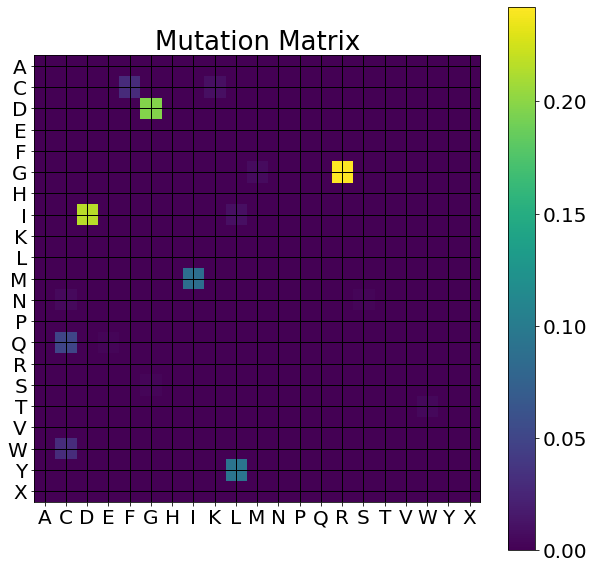

In [16]:
import matplotlib.pyplot as plt
#mutation_prob_matrix[2,4]-=1
fig = plt.figure(figsize=[10,10])
plt.imshow(mutation_prob_matrix)
plt.xticks(ticks=r, labels=labels)
plt.yticks(ticks=r, labels=labels)
plt.colorbar()
plt.title("Mutation Matrix")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

In [8]:
import pandas as pd

df = pd.read_csv("../results/20210519-113509/history.csv")

In [9]:
df.head()

,Unnamed: 0,Gen_G_loss,Cycle_X_loss,Disc_X_loss,Gen_F_loss,Cycle_Y_loss,Disc_Y_loss,x_acc,y_acc,x_c_acc,y_c_acc,temp_diff_x,temp_diff_y
0,0,0.474830,4.014223,1.447416,0.474834,2.465245,1.447505,0.054315,0.058340,0.050832,0.051777,1.304101,-33.748898
1,1,0.495192,4.188178,1.424216,0.500712,2.779504,1.420902,0.130955,0.113567,0.089906,0.087220,1.304101,-33.748898
2,2,0.502541,3.431057,1.426150,0.507345,2.564280,1.420448,0.266862,0.265817,0.228366,0.233047,1.304101,-33.748898
3,3,0.520674,3.117328,1.405850,0.521448,2.108112,1.406667,0.261541,0.327139,0.277654,0.262413,1.304101,-33.748898
4,4,0.527082,2.927387,1.399101,0.529974,1.902640,1.397982,0.309156,0.373359,0.319742,0.314693,1.304101,-33.748898


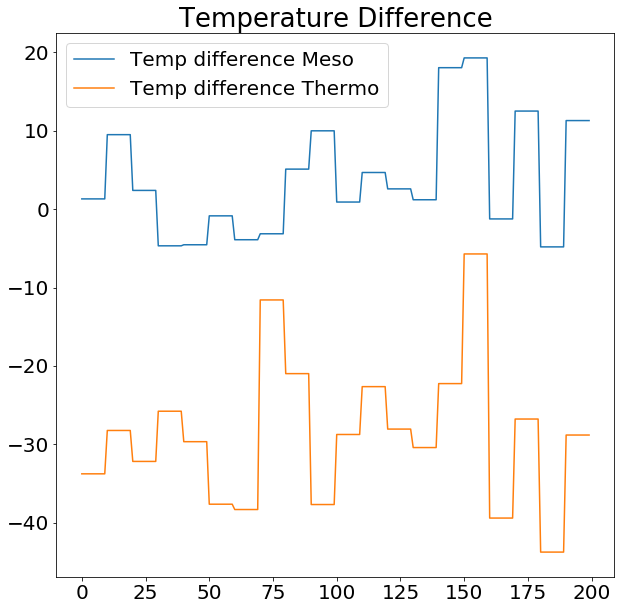

In [10]:

plt.figure(figsize=[10,10])
plt.plot(df["temp_diff_x"])
plt.plot(df["temp_diff_y"])
plt.legend(["Temp difference Meso", "Temp difference Thermo"])
plt.title("Temperature Difference")
plt.show()

In [11]:
from Bio import SeqIO

file = "../data/OGT_Classes/ogt_all.fasta"
id_list = []
for i, rec in enumerate(SeqIO.parse(file, "fasta")):
    id_list.append(rec.id)
    
with open("../data/OGT_Classes/ogt_all.id", "w") as f:
    for i in id_list:
        f.write("{}\n".format(i))

In [17]:
dir_results = "../results/20210519-213240/"

batches_x = data['meso_val'].batch(config['CycleGan']['batch_size'], drop_remainder=True) 
batches_y = data['thermo_val'].batch(config['CycleGan']['batch_size'], drop_remainder=True)

mutation_prob_matrix = np.zeros([21,21])
concerved_prob_matrix = np.zeros([21,21])

conc = tf.constant([[0.0, 0.0]])
conc_random = tf.constant([[0.0]])
for step, batch_data in enumerate(zip(batches_x,batches_y)):
    _, X_bin, W_x = batch_data[0]
    _, Y_bin, W_y= batch_data[1]
    
    #W_x = tf.cast(W_x, dtype=tf.int64)
    #W_y = tf.cast(W_y, dtype=tf.int64)
    # Fake data
    X_int = tf.math.argmax(X_bin, axis=-1)
    fake_y, _ = model.G(X_bin, training=True)
    fake_y_int = tf.math.argmax(fake_y, axis= -1) 
    fake_y_onehot = tf.one_hot(fake_y_int, 21)
    
    W_x_tmp = tf.repeat(tf.reshape(W_x, shape=(32,512,1)), 21, axis = -1)
    
    # Random data
    mask = tf.cast(tf.random.uniform(shape=[32,512], minval=0, maxval=3, dtype = tf.int64), dtype=tf.bool)
    random_val = tf.random.uniform(shape=[32,512], minval=0, maxval=21, dtype = tf.int64)
    X_random = tf.where(tf.cast(W_x, dtype=tf.bool), x=X_int, y=random_val, name=None)
    X_random_onehot = tf.one_hot(X_random, 21)
    X_random_int = tf.where(tf.cast(W_x, dtype=tf.bool), x=X_random, y=100, name=None)
    X_random_onehot = tf.math.multiply(X_random_onehot, W_x_tmp)
    temp_random = model.classifier(X_random_onehot)
    
    fake_y_onehot = tf.math.multiply(fake_y_onehot, W_x_tmp)
    temp_fake_y = model.classifier(fake_y_onehot)
    temp_X = model.classifier(X_bin)
    
    temp_diff = temp_fake_y - temp_X
    temp_diff_random = temp_random - temp_X
    
    X_int = tf.where(tf.cast(W_x, dtype=tf.bool), x=X_int, y=100, name=None)

    e = tf.math.equal(X_int, fake_y_int)
    c = tf.cast(e, tf.float32)

    id_diff   = tf.reshape(tf.reduce_sum(c, axis = -1) / tf.reduce_sum(W_x, axis = -1), shape= (32,1))

    conc = tf.concat([conc,tf.concat([temp_diff, id_diff], axis=-1, name='concat')], axis = 0)
    conc_random = tf.concat([conc_random,temp_diff_random], axis = 0)

In [18]:
temp_diff_id_diff = conc.numpy()
temp_diff_random  = conc_random.numpy()

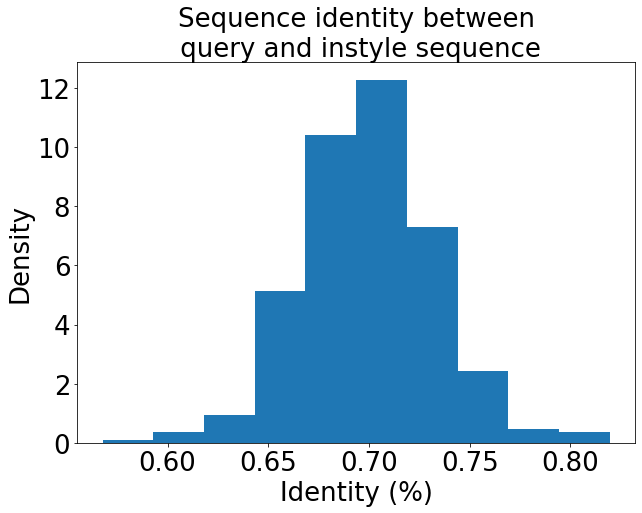

In [30]:
plt.figure(figsize=[10,7])
plt.hist(temp_diff_id_diff[1:,1], density=True)
plt.title("Sequence identity between\n query and instyle sequence")
plt.xlabel("Identity (%)")
plt.ylabel("Density")
plt.show()

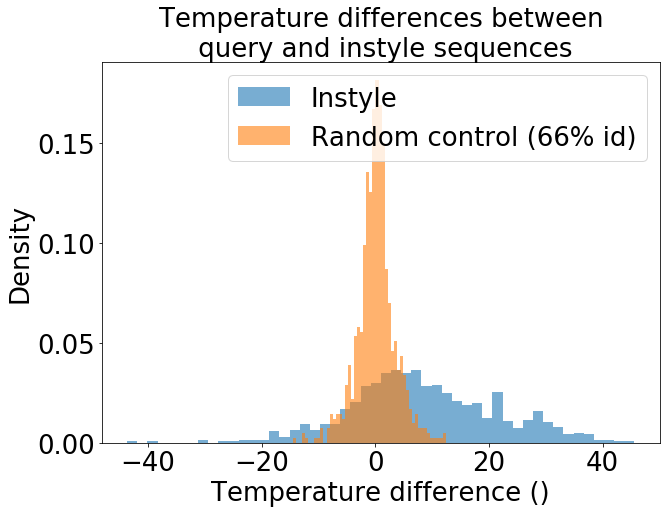

In [31]:
plt.figure(figsize=[10,7])
plt.hist(temp_diff_id_diff[1:,0], bins = 50, density = True, alpha = 0.6)
plt.hist(temp_diff_random[1:], bins = 50, density = True, alpha= 0.6)
plt.legend(["Instyle", "Random control (66% id)"])
plt.xlabel("Temperature difference ()")
plt.ylabel("Density")
plt.title("Temperature differences between\n query and instyle sequences")
plt.show()

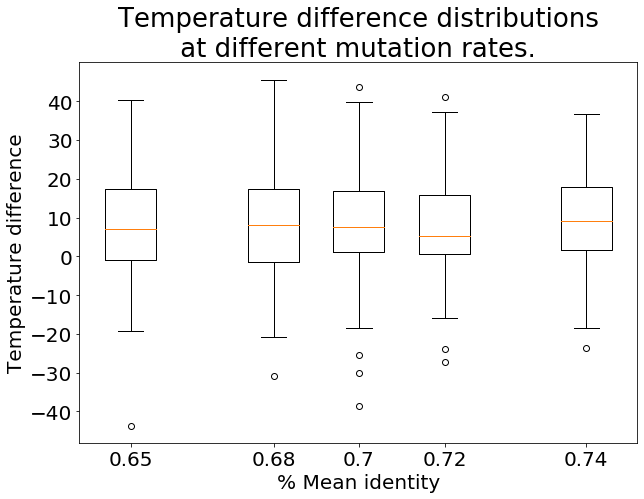

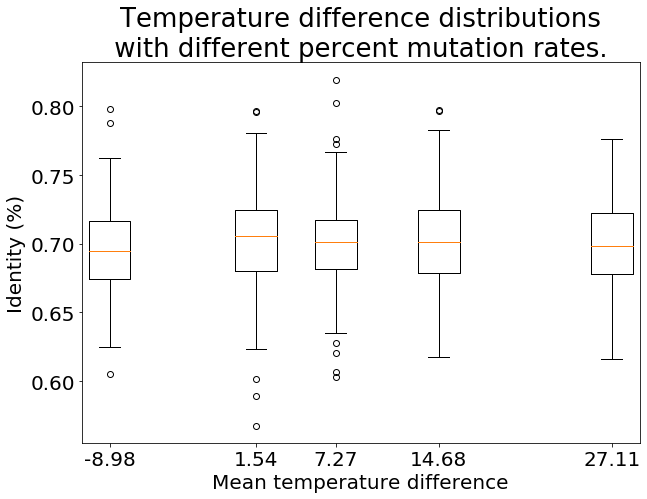

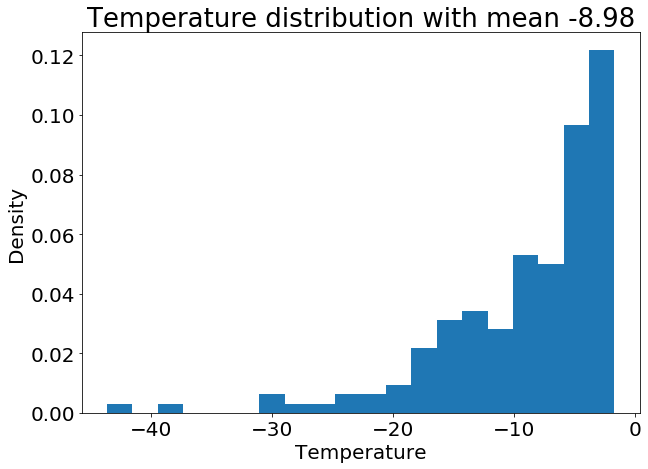

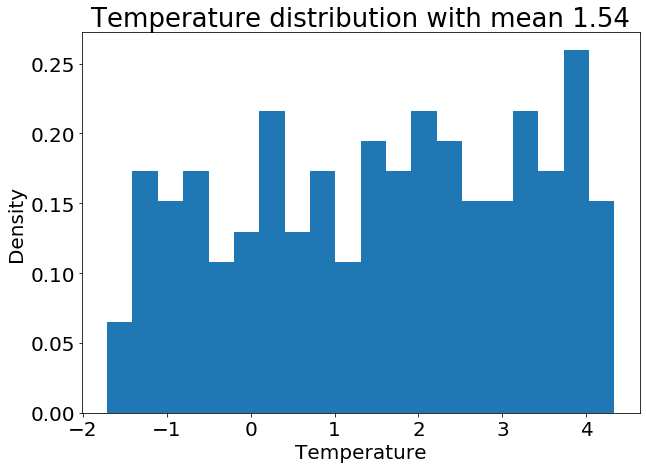

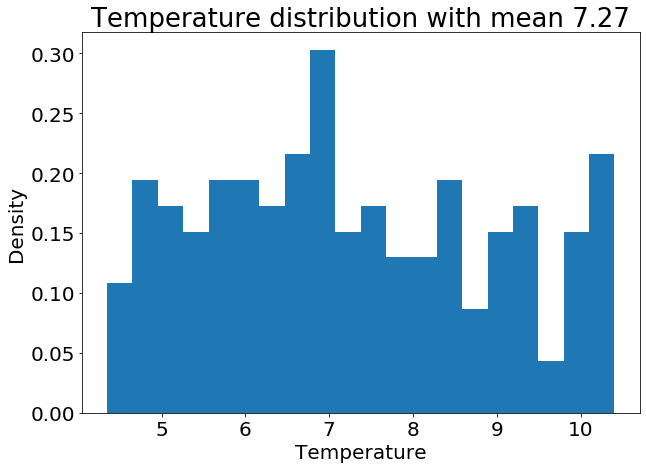

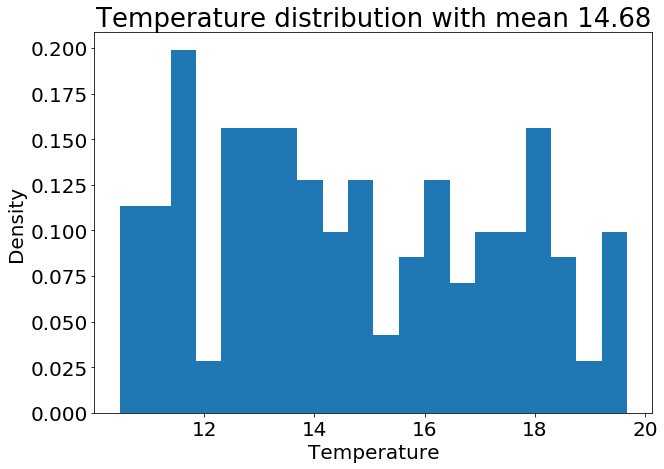

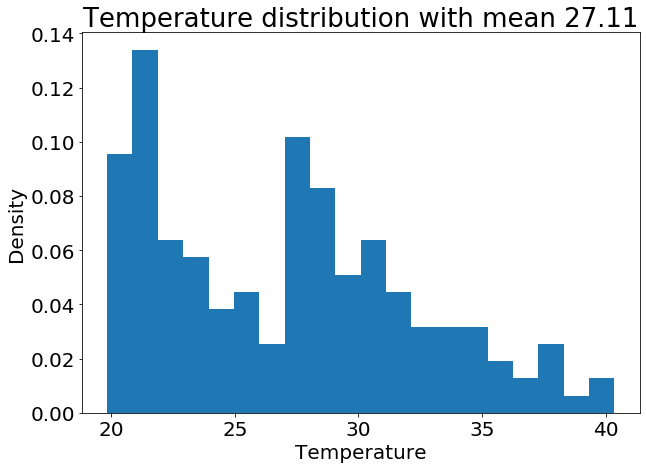

In [27]:
n_splits = 5
clean_TempId_diff = temp_diff_id_diff[1:,:] # stripp the leading zeros

f_temp = clean_TempId_diff[clean_TempId_diff[:, 1].argsort()] # ssort in terms of id
f_id = clean_TempId_diff[clean_TempId_diff[:, 0].argsort()]   # sort in terms of temperature

step = f_temp.shape[0]//n_splits


l_temp = [f_temp[step*i:step*(i+1),0] for i in range(n_splits)]
l_id   = [f_temp[step*i:step*(i+1),1] for i in range(n_splits)]

id_temp = [f_id[step*i:step*(i+1),0] for i in range(n_splits)]
id_id   = [f_id[step*i:step*(i+1),1] for i in range(n_splits)]

men_temp = [np.mean(i) for i in l_id]
men_temp_str = [str(round(i, 2)) for i in men_temp]

men_id = [np.mean(i) for i in id_temp]
men_id_str = [str(round(i, 2)) for i in men_id]

plt.figure(figsize=[10,7])

plt.boxplot(l_temp, positions = men_temp, widths=0.01)
plt.xlim([min(men_temp)-0.01, max(men_temp)+0.01])
plt.xticks(men_temp, labels=men_temp_str)
plt.yticks([-40, -30, -20, -10, 0, 10, 20, 30, 40])
#plt.xscale("log")
plt.xlabel("% Mean identity")
plt.ylabel("Temperature difference")
plt.title("Temperature difference distributions\n at different mutation rates. ")



plt.figure(figsize=[10,7])

plt.boxplot(id_id, positions = men_id, widths=3)
plt.xlim([min(men_id)-2, max(men_id)+2])
plt.xticks(men_id, labels=men_id_str)
#plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
#plt.ylim([0.4, 1.0])
plt.xlabel("Mean temperature difference")
plt.ylabel("Identity (%)")
plt.title("Temperature difference distributions\n with different percent mutation rates. ")


for idx, data in  enumerate(id_temp):
    plt.figure(figsize=[10,7])
    plt.hist(data, density=True, bins = 20)
    plt.title("Temperature distribution with mean {}".format(men_id_str[idx]))
    plt.xlabel("Temperature")
    plt.ylabel("Density")


plt.show()

In [22]:
print(f_id)

[[-43.635475     0.66292137]
 [-38.563187     0.6943867 ]
 [-30.802376     0.69078946]
 ...
 [ 41.22251      0.717608  ]
 [ 43.63739      0.69207317]
 [ 45.608765     0.6761229 ]]


In [115]:
temp_diff_4

array([-2.33495426e+01,  1.05922289e+01, -1.09916096e+01,  7.73945284e+00,
        1.32714453e+01,  1.24204636e+01,  2.65278511e+01, -4.30996418e+00,
        3.60662384e+01, -3.70657539e+00, -1.05204773e+00,  3.00733185e+00,
        1.36508751e+00, -2.36034393e+00,  9.85334206e+00,  1.29446583e+01,
       -2.21706581e+00, -2.04880142e+01,  3.18914032e+00, -2.15369759e+01,
       -8.64950657e+00,  3.33444328e+01,  9.30205345e-01, -8.57594299e+00,
        6.26679277e+00, -1.83846817e+01,  1.49740496e+01,  3.53600731e+01,
        2.80648613e+00, -2.19162178e+00,  1.11030312e+01,  9.74073219e+00,
        1.64139919e+01,  1.54754896e+01,  9.53402138e+00, -4.13970947e-02,
        7.76016521e+00,  2.47261982e+01,  1.33894196e+01,  3.12854271e+01,
        2.18363686e+01,  3.23919907e+01,  2.66008759e+00, -1.47935791e+01,
       -1.11092873e+01,  6.74997902e+00,  3.08127213e+00,  2.36519032e+01,
        1.72034950e+01,  1.30248022e+01,  1.26882448e+01,  3.03505535e+01,
       -1.85282288e+01, -

In [231]:
f_temp = temp_diff_id_diff[:10,:][temp_diff_id_diff[:10,:][:, 1].argsort()]

print(temp_diff_id_diff[:10,:])
print(f_temp)

[[  0.           0.        ]
 [-29.743214     0.7591241 ]
 [  4.1625595    0.70149255]
 [  2.3985085    0.7220339 ]
 [ 34.203613     0.72762644]
 [ 19.481695     0.66341466]
 [ 22.371815     0.66409266]
 [ 11.028455     0.66584766]
 [  4.1651764    0.7246377 ]
 [  8.938265     0.6519337 ]]
[[  0.           0.        ]
 [  8.938265     0.6519337 ]
 [ 19.481695     0.66341466]
 [ 22.371815     0.66409266]
 [ 11.028455     0.66584766]
 [  4.1625595    0.70149255]
 [  2.3985085    0.7220339 ]
 [  4.1651764    0.7246377 ]
 [ 34.203613     0.72762644]
 [-29.743214     0.7591241 ]]
